In [7]:
import random
import numpy as np
import matplotlib
import sys
import numba
import time
import multiprocessing as mp
from numba import jit, prange
from numba import config, njit, threading_layer
from matplotlib import pyplot as plt

### NOTEBOOK 2
### Indhold: 
Udvidet Prisoner's dilemma Tilføjet Nuke mulighed \
Almindelig Q-learner, master Q-learner \
Tilføjet master-theta eller epsilon, ændring over generationer

In [8]:
#random.seed(1235)
#Demand function from Klein (2020)
@njit
def PD_rewards(p1,p2):
    x = np.array(
            [[(3,3), (0,5), (-25,-25)],
            [(5,0), (1,1), (-25,-25)],
             [(-25,-25), (-25,-25), (-25,-25)]]
             )
    val_p1, val_p2 = x[p1,p2]
    
    return val_p1, val_p2
        

In [9]:

@njit
def master_q_player(prices, Q, epsilon, p2,t):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[t,:,p2]))
    return p3

In [10]:
@njit
def npc_player_gen2(options, q_table, epsilon, prev, time):
    if prev[time-2] ==0 and prev[time-1]==0 and prev[time]==0:
        npc_choice = 1
    elif prev[time] == 1:
        npc_choice = 0
    else:
        npc_choice = prev[time]

    return npc_choice

In [11]:
@njit
def regular_update(Q, prev, alpha, delta, prices, indic):
     if indic == 1: 
         p1 = prev[0,0]
         p2 = prev[1,0]
         p22 = prev[1,1]
         pe1 = Q[prev[0,0],prev[1,0]]
         ne1 = p1*PD_rewards(p1,p2)[0] + delta* p1*PD_rewards(p1,p22)[0] + delta**2 * Q[np.argmax(Q[:,prev[1,1]]),prev[1,1]]
         Q[prev[0,0], prev[1,0]] = (1-alpha) * pe1 + alpha * ne1
         #print('GAME player 1 ne and pe', ne1, pe1)
     else: 
        p1 = prev[1,0]
        p2 = prev[0,0]
        p22 = prev[0,1]
        pe2 = Q[prev[1,0],prev[0,0]]
        ne2 = p1*PD_rewards(p1,p2)[1] + delta* p1*PD_rewards(p1,p22)[1] + delta**2 * Q[np.argmax(Q[:,prev[0,1]]),prev[0,1]]
        Q[prev[1,0], prev[0,0]] = (1-alpha) * pe2 + alpha * ne2

@njit
def simple_Q_learner(prices, Q, epsilon, p2):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[:,p2]))
    return p3

In [42]:

@njit
def update(Q, prev, alpha, delta, prices, Current_t, previous_t, time, interval):
        my_old_price = prev[0,0]
        their_old_price = prev[1,0]
        their_new_choice = prev[1,1]
        intervals = np.shape(Q)[0]
        
        # Current_t = numba.int64(np.floor(time/interval_size))
        # previous_t = numba.int64(np.floor((time-1)/interval_size))
                
        #print('indices',prev[0,0],prev[1,0],prev_time)
        #print('prices', my_old_price, their_new_choice, their_old_price)
        prev_q_est = Q[previous_t, prev[0,0],prev[1,0]]
        #print('PD_reward', PD_rewards(my_old_price,their_old_price))
        #print('argmax i Q', Q[Current_t, np.argmax(Q[Current_t,:,prev[1,1]]),prev[1,1]])
        #print("PREV", prev[0,1])
        
        
        
        new_q_est = PD_rewards(my_old_price,their_old_price)[0] + delta* PD_rewards(my_old_price,their_new_choice)[0] + delta ** 2 * Q[Current_t, np.argmax(Q[Current_t,:,prev[1,1]]),prev[1,1]]
        #print("New Q est", new_q_est)
        prev_interval = max(0,Current_t-1)
        next_interval = min(intervals-1, Current_t+1)
        
        #print("operation",(time/interval) - Current_t)
        #if (time/interval) - Current_t < 0.5:
        #        prev_w = 0.5 - abs((time/interval) - prev_interval )
        #        curr_w = 1-prev_w
        #        Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + prev_w * Q[prev_interval, prev[0,0], prev[1,0]])
        #else:
        #        next_w = 0.5 - abs((time/interval) - next_interval) 
        #        curr_w = 1-next_w
        #        Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + next_w * Q[next_interval, prev[0,0], prev[1,0]])


        w_1 =  ( next_interval - time/interval) / (next_interval - prev_interval)
        w_2 =  (time/interval - prev_interval) / (next_interval - prev_interval) 
        #print('VÆGTE!!!:', w_1, w_2) 
        Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (w_2 * new_q_est + w_1 * Q[next_interval, prev[0,0], prev[1,0]])
        #curr_w = 1-prev_w
        #Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + next_w * Q[next_interval, prev[0,0], prev[1,0]] + prev_w * Q[prev_interval, prev[0,0], prev[1,0]])

In [184]:
@njit
def PD_game(q_table, options, periods, alpha, theta, delta, master_theta):
    a = len(options)
    Simple_Q_Table = np.zeros((a, a))
    interval_size = periods/15
    prev_choices = np.zeros((2,2), dtype=numba.int64)
    reward_arr = np.zeros(int(periods-2))
    reward_arr_p2 = np.zeros(int(periods-2))
    all_choices1 =np.zeros(int(periods/2)-1)
    all_choices2 =np.zeros(int(periods/2)-1)
    i_counter = 0
    j_counter = 0
    t=3
    if np.shape(q_table) != (15,a,a):
        print("Wrong dimensions")
    else:
        for t in range(t, periods+1):
        
            epsilon = (1-theta)**t
            master_epsilon = (1-master_theta)**t
            if t % 2 != 0: 
                time_for_q = int(np.floor(t/interval_size))
                prev_time_for_q = int(np.floor((t-1)/interval_size))
                #print("TimeCHeck",time_for_q,time_for_q)
                #print('time for q', time_for_q, 'prev time for q', prev_time_for_q, "prev", prev_choices)
                update(q_table, prev_choices, alpha, delta, options, time_for_q, prev_time_for_q, t, interval_size)
                p_i = master_q_player(options, q_table, master_epsilon, prev_choices[1,1], time_for_q)

                #In Case of Q opponent:
                #regular_update(Simple_Q_Table, prev_choices, alpha, delta, options, 1)
                #p_i = simple_Q_learner(options, Simple_Q_Table, epsilon, prev_choices[1,1])
                
                prev_choices[0,0] = prev_choices[0,1]
                prev_choices[0,1] = p_i
                prev_choices[1,0] = prev_choices[1,1]
                all_choices1[i_counter] = (options[p_i])
                i_counter += 1
                #print('Spiller 1 tur: p:', prices[p_i],' p_j: ', prices[prev_p[1,1]],'iteration:', t,'Q_table: \n', Q_table)
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
            else: 
                #In Case of Q opponent:
                regular_update(Simple_Q_Table, prev_choices, alpha, delta, options, 2)
                p_j = simple_Q_learner(options, Simple_Q_Table, epsilon, prev_choices[0,1])
                #a hard coded opponent: 
                #p_j= npc_player_gen2(options, q_table, 0, all_choices1, allchoices2, j_counter)
                
                
                prev_choices[1,0] = prev_choices[1,1]
                prev_choices[1,1] = p_j
                prev_choices[0,0] = prev_choices[0,1]
                all_choices2[j_counter] = (options[p_j])
                j_counter += 1
                #print('Spiller 2 tur: p:', prices[p_j], 'p_i', prices[prev_p[0,1]],' iteration: ', t,'Q_table2: \n', Q_table2)
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
                #step_counter +=1
    return all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table, Simple_Q_Table





    
    

In [249]:
def many_games(prices, periods, alpha, theta, learners, delta, init_q):
    total_pro_arr = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_pro_arr2 = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_opt_arr = np.zeros((learners, 49), dtype = np.ndarray)
    avg_profit = np.zeros(learners)
    avg_profit2 = np.zeros(learners)
    change_arr = np.zeros((1,25))
    change_arr2 = np.zeros((1,25))
    init_Q = init_q #np.zeros((10,2,2))
    CC_arr = np.zeros((learners,15))
    for i in range(learners):
        print('run #',i+1 ,'of ', learners , 'runs')
        #master_theta = theta
        #master_theta = 0.087988
        #master_epsilon= (1-master_theta)**i
        master_theta = theta*((i**1.25)/learners)
        all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table, q_table_simple= PD_game(init_Q, prices, periods, alpha, theta, delta, master_theta)
        total_pro_arr[i] = reward_arr
        total_pro_arr2[i] = reward_arr_p2
        #total_opt_arr[i] = arr_opt_i
        avg_profit[i] = np.mean(reward_arr[-10000:])
        avg_profit2[i] = np.mean(reward_arr_p2[-10000:])
        for t in range(15):
            CC_arr[i,t] = q_table[t,2,1]
        init_Q = q_table
        
    return total_pro_arr, total_pro_arr2, avg_profit, avg_profit2, init_Q, q_table_simple, all_choices1, all_choices2, CC_arr

In [250]:
options = np.array([0,1,2])
init_Q = np.zeros((15,3,3))
#old theta: 0.0000922
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q, simple_q, choices1, choices2, CC_arr = many_games(options, 100000, 0.3, 0.00009199, 100 ,0.95, init_Q)
final_Q

run # 1 of  100 runs
run # 2 of  100 runs
run # 3 of  100 runs
run # 4 of  100 runs
run # 5 of  100 runs
run # 6 of  100 runs
run # 7 of  100 runs
run # 8 of  100 runs
run # 9 of  100 runs
run # 10 of  100 runs
run # 11 of  100 runs
run # 12 of  100 runs
run # 13 of  100 runs
run # 14 of  100 runs
run # 15 of  100 runs
run # 16 of  100 runs
run # 17 of  100 runs
run # 18 of  100 runs
run # 19 of  100 runs
run # 20 of  100 runs
run # 21 of  100 runs
run # 22 of  100 runs
run # 23 of  100 runs
run # 24 of  100 runs
run # 25 of  100 runs
run # 26 of  100 runs
run # 27 of  100 runs
run # 28 of  100 runs
run # 29 of  100 runs
run # 30 of  100 runs
run # 31 of  100 runs
run # 32 of  100 runs
run # 33 of  100 runs
run # 34 of  100 runs
run # 35 of  100 runs
run # 36 of  100 runs
run # 37 of  100 runs
run # 38 of  100 runs
run # 39 of  100 runs
run # 40 of  100 runs
run # 41 of  100 runs
run # 42 of  100 runs
run # 43 of  100 runs
run # 44 of  100 runs
run # 45 of  100 runs
run # 46 of  100 ru

array([[[-54.17193045, -53.32162802, -53.72476145],
        [-18.26170827, -36.55683345, -78.20262454],
        [-89.72306149, -77.55212318, -84.47007115]],

       [[-18.04375294, -36.21578678, -43.9563253 ],
        [  1.47475173, -13.5285477 , -57.84894513],
        [-40.45044147, -53.13216699, -57.73032944]],

       [[  1.58885876,  28.97543684,  -9.67493889],
        [ 30.75507491,  -5.24045638, -27.09263895],
        [-25.93780577, -15.38264189, -39.02955539]],

       [[  8.8489425 ,  27.3381885 ,   7.35523774],
        [ 30.84721321,   5.08242877, -20.84488868],
        [-17.43108589, -12.7636045 , -22.92690088]],

       [[  4.22329362,  27.17405005, -20.19343143],
        [ 29.09597511,   4.38106196,  -9.19640297],
        [-11.05847329, -11.38415538, -18.89726564]],

       [[ 21.50930671,  41.60589069, -15.56835453],
        [ 43.18825618,   4.11244989,  12.19992185],
        [-10.38533303, -12.02803779, -13.84499055]],

       [[  9.76404556,  44.20002737, -18.43590535],


In [251]:
final_Q.shape

(15, 3, 3)

In [252]:
np.set_printoptions(threshold=sys.maxsize)
print(np.where(choices1==2))

(array([    1,     4,     5,     9,    10,    16,    17,    25,    29,
          32,    33,    34,    35,    43,    46,    47,    48,    49,
          50,    51,    55,    56,    59,    62,    65,    66,    67,
          68,    75,    78,    79,    84,    85,    86,    90,    93,
          96,   100,   101,   103,   105,   106,   108,   111,   112,
         116,   123,   124,   125,   130,   136,   137,   138,   141,
         143,   144,   146,   149,   161,   167,   170,   173,   175,
         179,   180,   181,   184,   192,   196,   199,   208,   209,
         210,   211,   224,   232,   234,   250,   256,   257,   258,
         260,   261,   269,   270,   273,   278,   279,   281,   282,
         289,   291,   292,   295,   298,   299,   301,   305,   306,
         309,   314,   317,   323,   325,   327,   328,   329,   330,
         340,   350,   357,   358,   366,   367,   377,   380,   383,
         385,   387,   395,   396,   407,   408,   410,   412,   416,
         419,   421

In [253]:
CC_arr
CC_arr.shape

(100, 15)

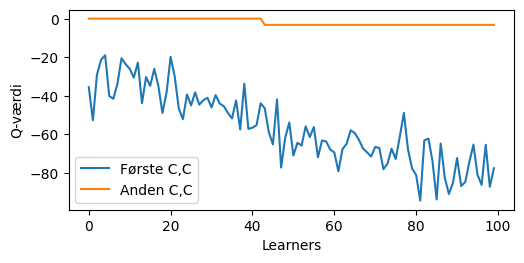

In [254]:
arr = np.transpose(CC_arr)
t = np.arange(0,100,1)

arr.shape
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t,arr[0],'-',label='Første C,C')
plt.plot(t,arr[14],'-', label='Anden C,C')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Learners")
plt.ylabel("Q-værdi")
#plt.axhline(y=3, color='k', linestyle = '--')
#plt.axhline(y=, color='k', linestyle = '--')
#plt.ylim(-2,5)
plt.legend()
plt.show()

In [255]:
def moving_avg(fst_arr, snd_arr, window_size):

    moving_averages = []
    moving_averages2 = []
    i = 0
    while i < len(fst_arr) - window_size + 1:
    
        # Calculate the average of current window
        window_average = np.sum(fst_arr[
        i:i+window_size]) / window_size
        window_average2 = np.sum(snd_arr[
        i:i+window_size]) / window_size
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        moving_averages2.append(window_average2)

        
        # Shift window to right by one position
        i += 1
    return moving_averages, moving_averages2

def prof_means(prof_arr1, prof_arr2):
    return np.mean(prof_arr1, axis=0), np.mean(prof_arr2, axis=0)

In [192]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

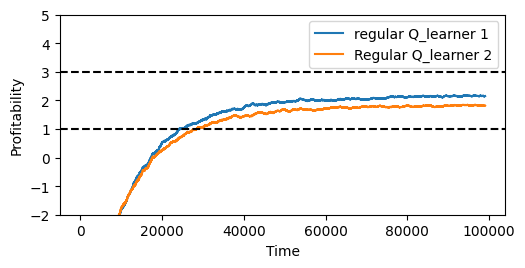

In [194]:

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='regular Q_learner 1 ')
plt.plot(t_arr2,profitability_arr2,'-', label='Regular Q_learner 2')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
plt.axhline(y=3, color='k', linestyle = '--')
plt.axhline(y=1, color='k', linestyle = '--')
plt.ylim(-2,5)
plt.legend()
plt.show()

In [116]:
np.shape(rewards_p1)

(100, 99998)

In [129]:
first_fivep1 = rewards_p1[20:25,:]
first_fivep2 = rewards_p2[20:25,:]

last_fivep1 = rewards_p1[-5:,:]
last_fivep2 = rewards_p2[-5:,:]

In [130]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

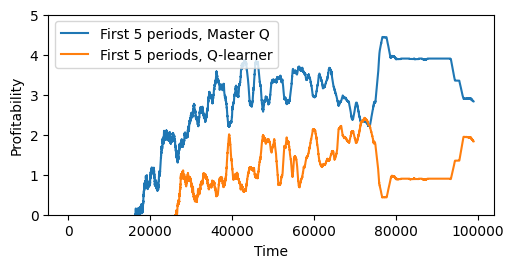

In [131]:
profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, 1000)
t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1_5,'-',label='First 5 periods, Master Q')
plt.plot(t_arr2,profitability_first2_5,'-', label='First 5 periods, Q-learner')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
plt.ylim(0,5)
plt.legend()
plt.show()

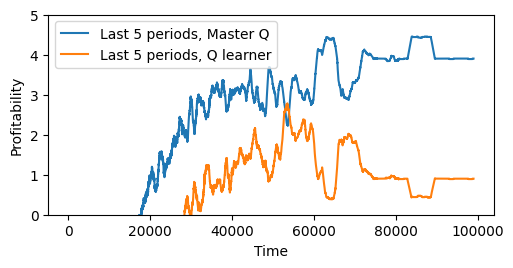

In [132]:
profitability_last1_5, profitability_last2_5 = moving_avg(last_prof1_5, last_prof2_5, 1000)
t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_last1_5,'-',label='Last 5 periods, Master Q')
plt.plot(t_arr2,profitability_last2_5,'-', label='Last 5 periods, Q learner')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
plt.ylim(0.00,5)
plt.legend()
plt.show()

In [84]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

In [19]:
options = np.array([0,1,2])
init_Q = np.zeros((15,3,3))
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q2 = many_games(options, 100000, 0.3, 0.0000922, 100 ,0.95, init_Q)
final_Q2

run # 1 of  100 runs
run # 2 of  100 runs
run # 3 of  100 runs
run # 4 of  100 runs
run # 5 of  100 runs
run # 6 of  100 runs
run # 7 of  100 runs
run # 8 of  100 runs
run # 9 of  100 runs
run # 10 of  100 runs
run # 11 of  100 runs
run # 12 of  100 runs
run # 13 of  100 runs
run # 14 of  100 runs
run # 15 of  100 runs
run # 16 of  100 runs
run # 17 of  100 runs
run # 18 of  100 runs
run # 19 of  100 runs
run # 20 of  100 runs
run # 21 of  100 runs
run # 22 of  100 runs
run # 23 of  100 runs
run # 24 of  100 runs
run # 25 of  100 runs
run # 26 of  100 runs
run # 27 of  100 runs
run # 28 of  100 runs
run # 29 of  100 runs
run # 30 of  100 runs
run # 31 of  100 runs
run # 32 of  100 runs
run # 33 of  100 runs
run # 34 of  100 runs
run # 35 of  100 runs
run # 36 of  100 runs
run # 37 of  100 runs
run # 38 of  100 runs
run # 39 of  100 runs
run # 40 of  100 runs
run # 41 of  100 runs
run # 42 of  100 runs
run # 43 of  100 runs
run # 44 of  100 runs
run # 45 of  100 runs
run # 46 of  100 ru

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
    

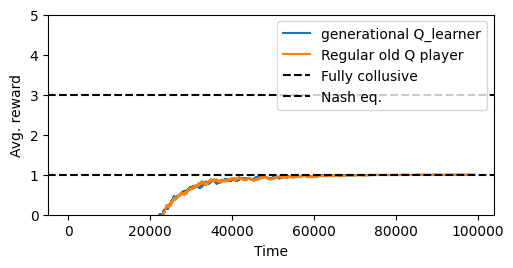

In [21]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='generational Q_learner')
plt.plot(t_arr2,profitability_arr2,'-', label='Regular old Q player')
plt.axhline(y=3, color='k', linestyle = '--', label='Fully collusive')
plt.axhline(y=1, color='k', linestyle = '--', label='Nash eq.')
plt.xlabel("Time")
plt.ylabel("Avg. reward")
plt.ylim(0,5)
plt.legend()
plt.show()

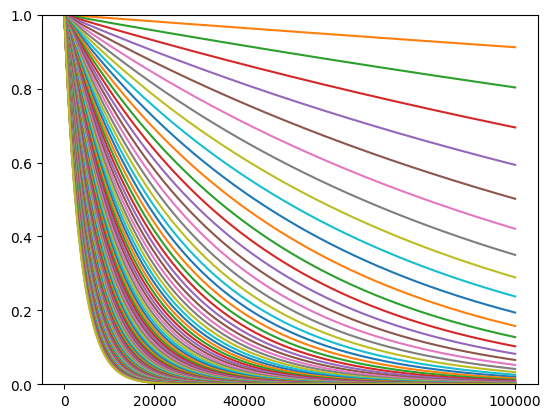

In [258]:
arr = np.zeros(100000)
t = np.arange(0,100000,1)
# def master_epsilon(theta,i,lean):
#     theta*(i**2/)
for j in range(0,99,1):
    for i in range(100000):
        arr[i] = (1-(0.0000922*(j**1.25)/100))**i

    plt.plot(t,arr,'-',label='generational Q_learner')

plt.ylim(0,1)
plt.show()

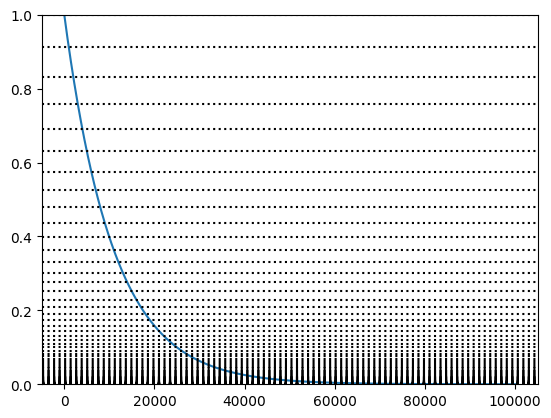

In [146]:
arr = np.zeros(100000)
t = np.arange(0,100000,1)
for i in range(100000):
    arr[i] = epsilon = (1-0.0000922)**i

arr2 = np.zeros(100)
t2 = np.arange(0,100,1)
for i in range(100):
    arr2[i] = epsilon = (1-0.087988)**i



plt.plot(t,arr,'-',label='generational Q_learner')
for i in arr2:
    plt.axhline(y=i, color='k', linestyle = 'dotted')
plt.ylim(0,1)
plt.show()


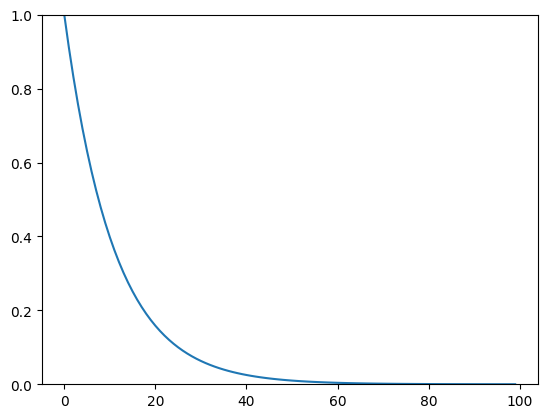

In [139]:
arr = np.zeros(100)
t = np.arange(0,100,1)
for i in range(100):
    arr[i] = epsilon = (1-0.087988)**i
plt.plot(t,arr,'-',label='generational Q_learner')
plt.ylim(0,1)
plt.show()